In [5]:
%matplotlib inline
from os import listdir
from os.path import isfile, join
import numpy as np
from glob import glob
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import matplotlib
import statsmodels.stats.multitest as smt
from sklearn.decomposition import PCA
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

In [2]:
## Read samples location info
dir_path = '/Users/osipova/Documents/LabDocs/Leatherback_popgen/'
file_name = 'dc_ALL_rounds_info.tsv'
file_data = glob(dir_path + file_name)[0]
INFO = pd.read_csv(file_data, sep='\t')[['Sample_ID', 'country', 'year', 'post_dupe_depth']]
INFO.rename(columns={'Sample_ID':'sample', 
                     'country':'country', 
                     'year':'year', 
                     'post_dupe_depth':'depth'}, inplace=True)

In [3]:
countries_order = ['Indonesia', 'Solomon_Islands', 'Malaysia', 'Papua_New_Guinea', 'Mexico', 'Virgin_Islands',
                   'French_Guiana', 'Suriname', 'Costa_Rica', 'Ghana', 'Gabon', 'South_Africa']

## 1. PCA analysis

In [9]:
# PCA files
dir_path = '/Users/osipova/Documents/LabDocs/Leatherback_popgen/'
out_dir = 'PCA_out/'
distance_matrix_file = dir_path + out_dir + "pca_turtles_ld_pruned.mdist"
sample_id_file = dir_path + out_dir + "pca_turtles_ld_pruned.mdist.id"

# Load the distance matrix
dist_matrix = np.loadtxt(distance_matrix_file)

# Load the sample IDs
sample_ids = pd.read_csv(sample_id_file, delim_whitespace=True, header=None, names=["FID", "IID"])

# Merge sample IDs with metadata
sample_metadata = pd.merge(sample_ids, INFO, left_on="IID", right_on="sample", how="left")

# Convert distance matrix to covariance matrix approximation
n_samples = dist_matrix.shape[0]
row_means = np.mean(dist_matrix, axis=1).reshape(-1, 1)
col_means = np.mean(dist_matrix, axis=0).reshape(1, -1)
total_mean = np.mean(dist_matrix)
cov_matrix = -0.5 * (dist_matrix**2 - row_means - col_means + total_mean)

# Perform PCA on the covariance matrix
pca = PCA(n_components=2)  # Adjust components if needed
pca_result = pca.fit_transform(cov_matrix)

# Combine PCA results with metadata
pca_df = pd.DataFrame(pca_result, columns=["PC1", "PC2"])
pca_df["IID"] = sample_ids["IID"]
pca_df = pd.merge(pca_df, INFO, left_on="IID", right_on="sample", how="left")

pca_df.head(3)

,PC1,PC2,IID,sample,country,year,depth
0,-0.023486,0.005710,dc_100028_bb_noq,dc_100028_bb_noq,Mexico,2016,14.38
1,-0.024210,0.005678,dc_100029_bb_noq,dc_100029_bb_noq,Mexico,2016,10.91
2,-0.024662,0.005606,dc_100030_bb_noq,dc_100030_bb_noq,Mexico,2016,16.44


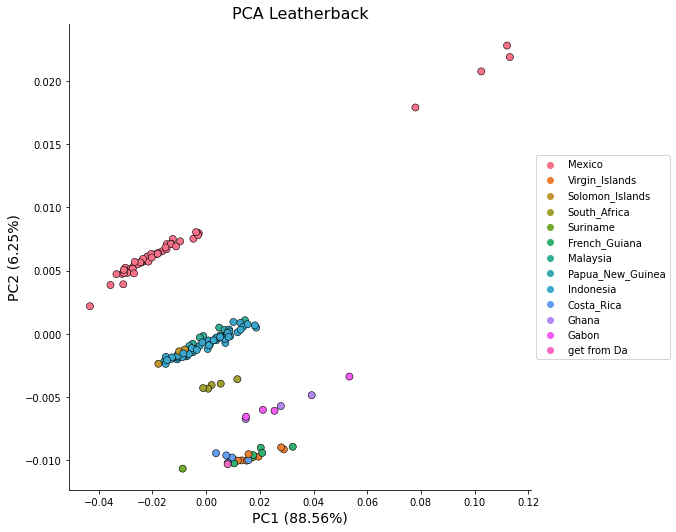

In [21]:
fig, axes = plt.subplots(figsize=(9.5, 7.5))

sns.scatterplot(data=pca_df, x='PC1', y='PC2', hue='country', s=50, edgecolor="black")

# Add explained variance
explained_variance = pca.explained_variance_ratio_ * 100
axes.set_xlabel(f"PC1 ({explained_variance[0]:.2f}%)", fontsize=14)
axes.set_ylabel(f"PC2 ({explained_variance[1]:.2f}%)", fontsize=14)
axes.legend(loc="center left", bbox_to_anchor=(1, 0.5))

# Customize plot
plt.title("PCA Leatherback", fontsize=16)

sns.despine(fig=None, ax=None, left=False, bottom=False, offset=None, trim=False)
fig.tight_layout()

## 2. Admixture analysis

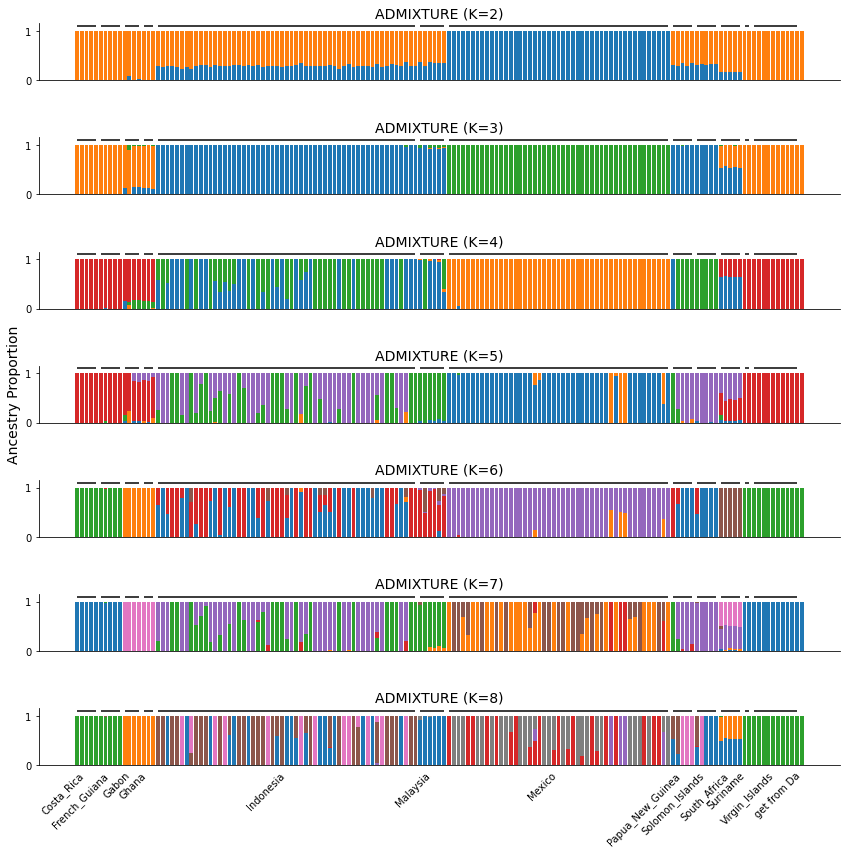

In [98]:
dir_path = '/Users/osipova/Documents/LabDocs/Leatherback_popgen/'
out_dir = "admixture_out/"
k_values = range(2, 9)

fig, axes = plt.subplots(len(k_values), 1, figsize=(12, 12))

for i in range(len(k_values)):
    k = k_values[i]
    
    # Load Q matrix
    file_name = "named.turtles_ld_pruned.{}.Q".format(k)
    file_data = glob(dir_path + out_dir + file_name)[0]
    q_matrix = pd.read_csv(file_data, sep="\t", names=['sample'] + list(range(1, k+1)), index_col=False)
    df_q = pd.merge(q_matrix, INFO, on='sample')
    df_q.sort_values('country', inplace=True,ignore_index=True)
    ax = axes[i]
    
    # Stacked bar plot for each individual
    bottom = pd.Series(0, index=df_q.index)
    for cluster in range(1, k+1):
        ax.bar(df_q.index, 
               df_q[cluster], 
               bottom=bottom)
        bottom += df_q[cluster]
    
    ax.set_title(f"ADMIXTURE (K={k})", fontsize=14)
    if i == 3:
        ax.set_ylabel("Ancestry Proportion", fontsize=14)
    ax.set_xticks([])


    # Calculate midpoints for country labels
    countries = df_q['country'].unique()
    positions = []
    labels = []
    line_ranges = []

    for country in countries:
        subset = df_q[df_q['country'] == country]
        midpoint = (subset.index[0] + subset.index[-1]) / 2
        positions.append(midpoint)
        labels.append(country)
        line_ranges.append((subset.index[0], subset.index[-1]))

    # Add horizontal lines above the plot
    line_y = 1.1
    for start, end in line_ranges:
        ax.hlines(y=line_y, xmin=start, xmax=end, color='black', linewidth=1.5)

    # Add country labels
    if i == len(k_values) - 1:
        for pos, label in zip(positions, labels):
            ax.text(pos, -0.1, label, ha='right', va='top', rotation=45)
    
sns.despine(fig=None, ax=None, left=False, bottom=False, offset=None, trim=False)
fig.tight_layout()